In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 5
fig_height = 4
fig_format = :png
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"C:\Users\CMILLER\jlcode\cap18\cap18 check\Report"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using Revise
using Plots, DataFrames, CSV, Tidier
using Cap18
import StatsPlots as stats

In [3]:
dir = pwd() * "/../"
gr()
legend_pos = :outertopright
x_size = 721
y_size = 400

trim(m::Cap18.Moments) = Cap18.Moments(m.dist[2:end-1], m.moments[2:end-1])
trim(m::Cap18.Shears) = Cap18.Shears(m.dist[2:end-1], m.shear[2:end-1])
trim(m::Cap18.MomentEnvelopes) = Cap18.MomentEnvelopes(m.dist[2:end-1], m.max_moment[2:end-1], m.min_moment[2:end-1])
trim(m::Cap18.ShearEnvelopes) = Cap18.ShearEnvelopes(m.dist[2:end-1], m.max_shear[2:end-1], m.min_shear[2:end-1]);

path = dir * "cap18_check.lis"
p = parse_cap18(path);

In [4]:
p1_tb4a = DataFrame(p[1].tb4a.results)
d_dc_cap18 = deflections(p[1].tb4a)
m_dc_cap18 = moments(p[1].tb4a) |> trim
s_dc_cap18 = shears(p[1].tb4a) |> trim;

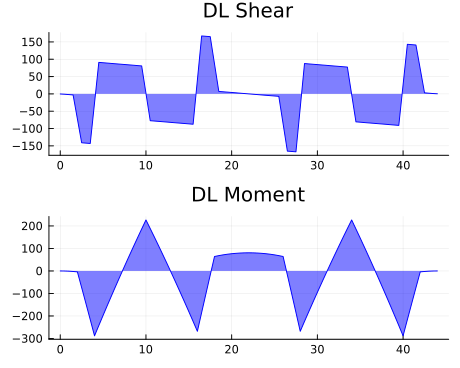

In [5]:
#| fig-cap: "Cap18: DL Shear and Moment Diagrams"
plot(
		# plot(d_dc_cap18, title = "DL Deflections"),
		plot(s_dc_cap18, title = "DL Shear"),
		plot(m_dc_cap18, title = "DL Moment"),
		layout = (2, 1)
	)

In [6]:
p1_tb6 = DataFrame(p[1].tb6ws.results);
smax_cap18_srv = max_shears(p[1].tb6ws) |> trim
smin_cap18_srv = min_shears(p[1].tb6ws) |> trim
se_cap18_srv = shear_envelopes(p[1].tb6ws) |> trim

mmax_cap18_srv = max_moments(p[1].tb6ws) |> trim
mmin_cap18_srv = min_moments(p[1].tb6ws) |> trim
me_cap18_srv = moment_envelopes(p[1].tb6ws) |> trim;

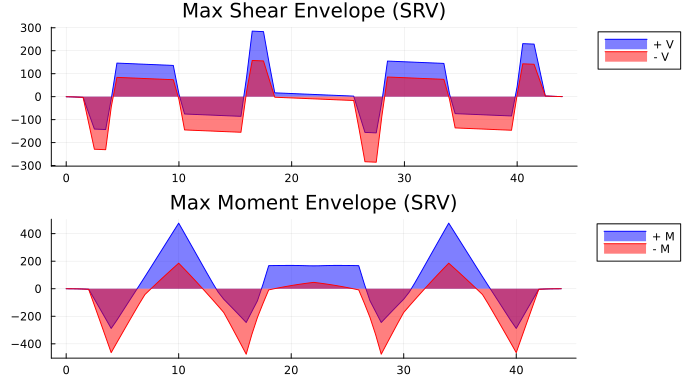

In [7]:
#| fig-cap: "Cap18: Service Shear and Moment Envelope Diagrams"
plot(
		plot(se_cap18_srv, title="Max Shear Envelope (SRV)"),
		plot(me_cap18_srv, title="Max Moment Envelope (SRV)"), 
		layout = (2, 1),
		legend = legend_pos,
		size = (x_size, y_size)
	)

In [8]:
#| tbl-cap: "Cap18: Service Reactions"
r_cap18_srv = DataFrame(p[1].tb7ws.results)

Row,sta,dist,max_reaction,min_reaction
,Int64,Float64,Float64,Float64
1,8,4.0,376.5,229.2
2,32,16.0,441.0,245.3
3,56,28.0,441.0,245.3
4,80,40.0,376.5,229.2


In [9]:
p1_tb6lf = DataFrame(p[1].tb6lf.results);
smax_cap18_str = max_shears(p[1].tb6lf) |> trim
smin_cap18_str = min_shears(p[1].tb6lf) |> trim
se_cap18_str = shear_envelopes(p[1].tb6lf) |> trim

mmax_cap18_str = max_moments(p[1].tb6lf) |> trim
mmin_cap18_str = min_moments(p[1].tb6lf) |> trim
me_cap18_str = moment_envelopes(p[1].tb6lf) |> trim;

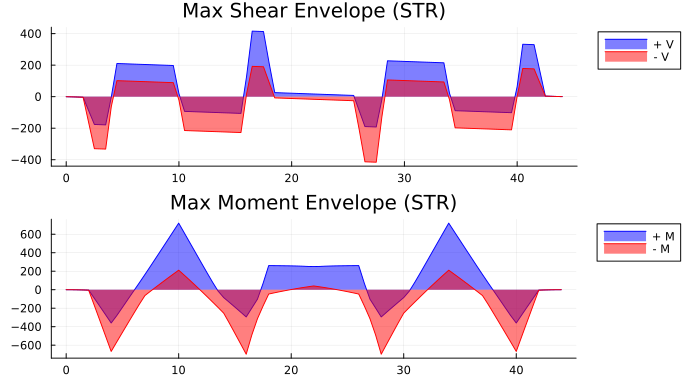

In [10]:
#| fig-cap: "Cap18: Strength Shear and Moment Envelope Diagrams"
plot(
		plot(se_cap18_str, title="Max Shear Envelope (STR)"),
		plot(me_cap18_str, title="Max Moment Envelope (STR)"), 
		layout = (2, 1),
		legend = legend_pos,
		size = (x_size, y_size)
	)

In [11]:
#| tbl-cap: "Cap18: Strength Reactions"
r_cap18_str = DataFrame(p[1].tb7lf.results)

Row,sta,dist,max_reaction,min_reaction
,Int64,Float64,Float64,Float64
1,8,4.0,540.9,283.0
2,32,16.0,643.3,300.9
3,56,28.0,643.3,300.9


In [12]:
function parse_larsa_moments(df)
	@chain df begin
		@clean_names
		@rename(moment_y = `moment_y_(kips_ft)`)
		@filter(member < 20000)
		# @filter(mod(member, 10000) == mod(joint, 1000))
		@mutate(moment_y = if_else(mod(member, 10000) == mod(joint, 1000),moment_y, -moment_y))
		@mutate(joint = (joint-1000)*0.5)
	    @group_by(joint)
	    @summarize(
			max_my = maximum(moment_y),
			min_my = minimum(moment_y)
		)
	    @select(joint, max_my, min_my)
		@ungroup
		Cap18.MomentEnvelopes(_.joint, _.max_my, _.min_my)
	end
end;

function parse_larsa_moments(df, sym)
	new_df = @chain df begin
		@clean_names
		@rename(moment_y = `moment_y_(kips_ft)`)
		@filter(member < 20000)
		# @filter(mod(member, 10000) == mod(joint, 1000))
		@mutate(moment_y = if_else(mod(member, 10000) == mod(joint, 1000),moment_y, -moment_y))
		@mutate(joint = (joint-1000)*0.5)
	    @group_by(joint)
	    @summarize(
			max_my = maximum(moment_y),
			min_my = minimum(moment_y)
		)
	    @select(joint, max_my, min_my)
		@ungroup
	end
	if sym == :maximum
		Cap18.Moments(new_df.joint, new_df.max_my)
	elseif sym == :minimum
		Cap18.Moments(new_df.joint, new_df.min_my)
	else
		error("Please enter `:maximum` or `:minimum` for sym. You entered $sym")
	end
end;

function parse_larsa_shears(df)
	@chain df begin
		@clean_names
		@rename(force_z = `force_z_(kips)`)
		@filter(member < 20000)
		# @filter(mod(member, 10000) == mod(joint, 1000))
		@mutate(force_z = if_else(mod(member, 10000) == mod(joint, 1000),force_z, -force_z))
		@mutate(joint = (joint-1000)*0.5)
	    @group_by(joint)
	    @summarize(
			max_fz = maximum(force_z),
			min_fz = minimum(force_z)
		)
	    @select(joint, max_fz, min_fz)
		@ungroup
		Cap18.ShearEnvelopes(_.joint, _.max_fz, _.min_fz)
	end
end;

function parse_larsa_shears(df, sym)
	new_df = @chain df begin
		@clean_names
		@rename(force_z = `force_z_(kips)`)
		@filter(member < 20000)
		# @filter(mod(member, 10000) == mod(joint, 1000))
		@mutate(force_z = if_else(mod(member, 10000) == mod(joint, 1000),force_z, -force_z))
		@mutate(joint = (joint-1000)*0.5)
	    @group_by(joint)
	    @summarize(
			max_fz = maximum(force_z),
			min_fz = minimum(force_z)
		)
	    @select(joint, max_fz, min_fz)
		@ungroup
	end
	if sym == :maximum
		Cap18.Shears(new_df.joint, new_df.max_fz)
	elseif sym == :minimum
		Cap18.Shears(new_df.joint, new_df.min_fz)
	else
		error("Please enter `:maximum` or `:minimum` for sym. You entered $sym")
	end
end;

function parse_larsa_reactions(path)
	df = dropmissing(CSV.read(path, DataFrame))
	@chain df begin
		@clean_names
		@rename(force_z = `force_z_(kips)`)
		@mutate(sta = (joint-1000))
	    @group_by(sta)
	    @summarize(
			dist = maximum((joint-1000)*0.5),
			max_reaction = maximum(force_z),
			min_reaction = minimum(force_z)
		)
	    @select(sta, dist, max_reaction, min_reaction)
		@ungroup
	end
end;

path_dc_larsa_srv = dir *"dc_larsa_srv.csv";
path_se_larsa_srv = dir *"se_larsa_srv.csv";
path_me_larsa_srv = dir *"me_larsa_srv.csv";
path_se_larsa_str = dir *"se_larsa_str.csv";
path_me_larsa_str = dir *"me_larsa_str.csv";
path_r_larsa_srv = dir *"r_larsa_srv.csv";
path_r_larsa_str = dir *"r_larsa_str.csv";

In [13]:
df_dc_larsa_srv = dropmissing(CSV.read(path_dc_larsa_srv, DataFrame));
m_dc_larsa = parse_larsa_moments(df_dc_larsa_srv, :maximum)
s_dc_larsa = parse_larsa_shears(df_dc_larsa_srv, :maximum);

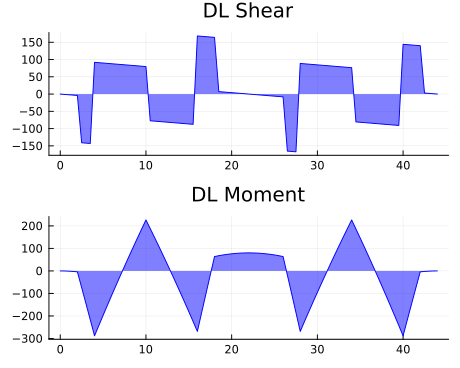

In [14]:
#| fig-cap: "LARSA: DL Shear and Moment Diagrams"
plot(
		# plot(d_dc_cap18, title = "DL Deflections"),
		plot(s_dc_larsa, title = "DL Shear"),
		plot(m_dc_larsa, title = "DL Moment"),
		layout = (2, 1)
	)

In [15]:
df_se_larsa_srv = dropmissing(CSV.read(path_se_larsa_srv, DataFrame))
df_me_larsa_srv = dropmissing(CSV.read(path_me_larsa_srv, DataFrame));

#shears
smax_larsa_srv = parse_larsa_shears(df_se_larsa_srv, :maximum)
smin_larsa_srv = parse_larsa_shears(df_se_larsa_srv, :minimum)
se_larsa_srv = parse_larsa_shears(df_se_larsa_srv)

# moments
mmax_larsa_srv = parse_larsa_moments(df_me_larsa_srv, :maximum)
mmin_larsa_srv = parse_larsa_moments(df_me_larsa_srv, :minimum)
me_larsa_srv = parse_larsa_moments(df_me_larsa_srv);

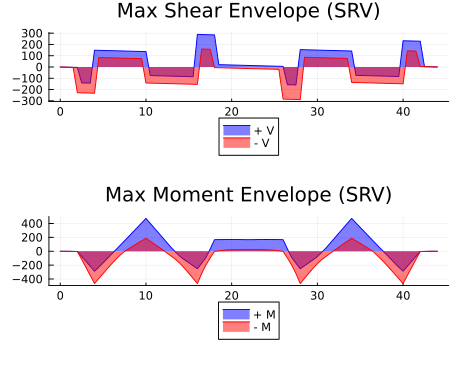

In [16]:
#| fig-cap: "LARSA: Service Shear and Moment Envelope Diagrams"
plot(
		plot(se_larsa_srv, title="Max Shear Envelope (SRV)"),
		plot(me_larsa_srv, title="Max Moment Envelope (SRV)"), 
		layout = (2, 1),
		legend = :outerbottom,
	)

In [17]:
#| tbl-cap: Service Reactions
r_larsa_srv = parse_larsa_reactions(path_r_larsa_srv)

Row,sta,dist,max_reaction,min_reaction
,Int64,Float64,Float64,Float64
1,8,4.0,376.619,229.487
2,32,16.0,439.42,247.414
3,56,28.0,439.42,247.414
4,80,40.0,376.577,229.49


In [18]:
df_se_larsa_str = dropmissing(CSV.read(path_se_larsa_str, DataFrame))
df_me_larsa_str = dropmissing(CSV.read(path_me_larsa_str, DataFrame));

#shears
smax_larsa_str = parse_larsa_shears(df_se_larsa_str, :maximum)
smin_larsa_str = parse_larsa_shears(df_se_larsa_str, :minimum)
se_larsa_str = parse_larsa_shears(df_se_larsa_str)

# moments
mmax_larsa_str = parse_larsa_moments(df_me_larsa_str, :maximum)
mmin_larsa_str = parse_larsa_moments(df_me_larsa_str, :minimum)
me_larsa_str = parse_larsa_moments(df_me_larsa_str);

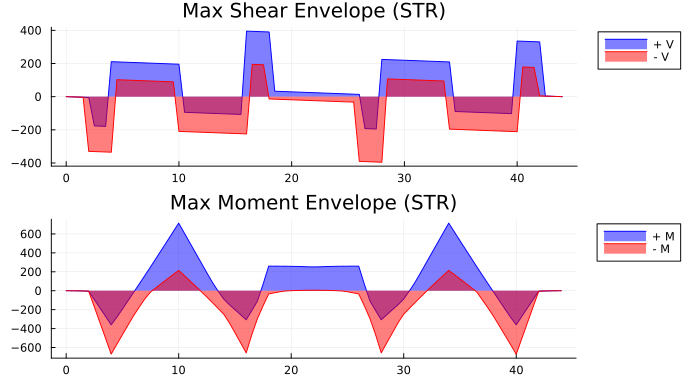

In [19]:
#| fig-cap: "LARSA: Strength Shear and Moment Envelope Diagrams"
plot(
		plot(se_larsa_str, title="Max Shear Envelope (STR)"),
		plot(me_larsa_str, title="Max Moment Envelope (STR)"), 
		layout = (2, 1),
			legend = legend_pos,
		size = (x_size, y_size)
	)

In [20]:
#| tbl-cap: "LARSA: Strength Reactions"
r_larsa_str = parse_larsa_reactions(path_r_larsa_str)

Row,sta,dist,max_reaction,min_reaction
,Int64,Float64,Float64,Float64
1,8,4.0,541.086,283.606
2,32,16.0,604.078,304.531
3,56,28.0,604.078,304.531
4,80,40.0,541.013,283.611


In [21]:
function plot_shear_comparison(s_cap18, s_larsa; title="Shear Comparison", fillalpha=0.5)
	shear_plt = plot(s_cap18, label="S cap18", fillalpha=fillalpha)
		plot!(s_larsa, fillcolor=:darkorange, lc=:darkorange, label="S larsa", fillalpha=fillalpha)
		plot!(s_cap18 - s_larsa, 
			fillalpha=1, fillcolor=:red, lc=:black, label="S diff",
			title = title
		)
	shear_plt
end;

function plot_moment_comparison(m_cap18, m_larsa; title="Moment Comparison", fillalpha=0.5)
	moment_plt = plot(m_cap18, title = "DL Shear", label="M cap18", fillalpha=fillalpha)
		plot!(m_larsa, fillcolor=:darkorange, lc=:darkorange, label="M larsa", fillalpha=fillalpha)
		plot!(m_cap18 - m_larsa, 
			fillalpha=1, fillcolor=:red, lc=:black, label="M diff",
			title = title
		)
	moment_plt
end;

function plot_comparison(s_cap18, s_larsa, m_cap18, m_larsa; 
    legend_pos=legend_pos,
    size = (x_size, y_size), 
    shear_title="Shear Comparison", 
    moment_title="Moment Comparison",
    shear_alpha=0.5,
    moment_alpha=0.5,
    )
        
        shear_plt = plot_shear_comparison(s_cap18, s_larsa, title=shear_title, fillalpha=shear_alpha)
        
        moment_plt = plot_moment_comparison(m_cap18, m_larsa, title=moment_title, fillalpha=moment_alpha)
            
            plot(
                shear_plt,
                moment_plt,
                layout = (2, 1),
                legend = legend_pos,
                size = size,
                plot_size=size
            )
end;

function plot_env_comparison(se_cap18_srv, se_larsa_srv, me_cap18_srv, me_larsa_srv; legend_pos=legend_pos, size = (x_size, y_size))
	shear_plt = plot(se_cap18_srv, maxlabel="+V cap18", minlabel="-V cap18")
	plot!(se_larsa_srv, lc=:black, maxlabel="+V larsa", minlabel="-V larsa")
	plot!(se_cap18_srv - se_larsa_srv, 
		fillalpha=1, maxcolor=:red, mincolor=:blue, lc=:black,
		maxlabel="+V diff", minlabel="-V diff",
		title="Shear Envelope Comparison"
	)

	moment_plt = plot(me_cap18_srv, maxlabel="+M cap18", minlabel="-M cap18")
	plot!(me_larsa_srv, lc=:black, maxlabel="+M larsa", minlabel="-M larsa")
	plot!(me_cap18_srv - me_larsa_srv, 
		fillalpha=1, maxcolor=:red, mincolor=:blue, lc=:black,
		maxlabel="+M diff", minlabel="-M diff",
		title="Moment Envelope Comparison"
	)
	
	plot(
		shear_plt,
		moment_plt,
		layout = (2, 1), 
		legend = legend_pos,
		size = size,
		plot_size=(600, 400)
	)
end;

function plot_max_comparison(se_cap18_srv, se_larsa_srv, me_cap18_srv, me_larsa_srv; legend_pos=legend_pos, size = (x_size, y_size))
	s_cap18 = max_shears(se_cap18_srv)
	s_larsa = max_shears(se_larsa_srv)

	m_cap18 = max_moments(me_cap18_srv)
	m_larsa = max_moments(me_larsa_srv)
	plot_comparison(s_cap18, s_larsa, m_cap18, m_larsa; legend_pos=legend_pos, size = size)
end;

function plot_min_comparison(se_cap18_srv, se_larsa_srv, me_cap18_srv, me_larsa_srv; legend_pos=legend_pos, size = (x_size, y_size))
	s_cap18 = min_shears(se_cap18_srv)
	s_larsa = min_shears(se_larsa_srv)

	m_cap18 = min_moments(me_cap18_srv)
	m_larsa = min_moments(me_larsa_srv)
	plot_comparison(s_cap18, s_larsa, m_cap18, m_larsa; legend_pos=legend_pos, size = size)
end;

function plot_difference(
	s_cap18, s_larsa, m_cap18, m_larsa;
	shear_title="Shear Difference",
	moment_title="Moment Difference",
)
	shear_plt = plot(s_cap18 - s_larsa, title = shear_title)
	moment_plt = plot(m_cap18 - m_larsa, title = moment_title)

	plot(
			shear_plt,
			moment_plt,
			layout = (2, 1),
			legend = legend_pos,
			size = (x_size, y_size)
		)
end;

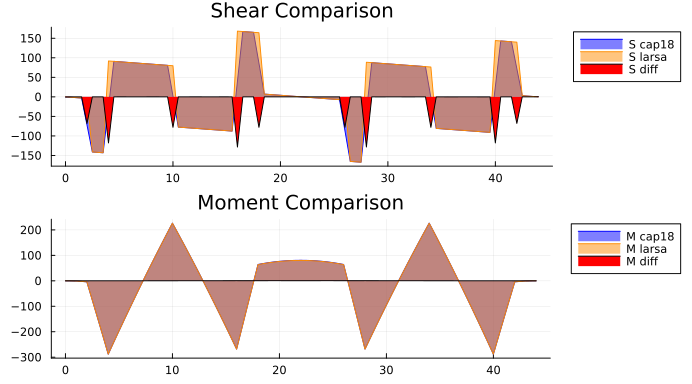

In [22]:
#| fig-cap: "Comparison: DL Shear and Moment Diagrams"
plot_comparison(
	s_dc_cap18, s_dc_larsa, m_dc_cap18, m_dc_larsa; 
	legend_pos=legend_pos, 
	size = (x_size, y_size),
	shear_alpha=0.5,
	moment_alpha=0.5,
)

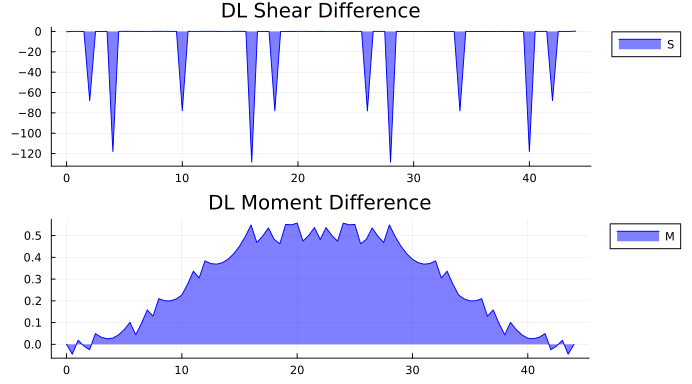

In [23]:
#| fig-cap: "Comparison: DL Shear and Moment Difference"
plot_difference(
	s_dc_cap18, s_dc_larsa, m_dc_cap18, m_dc_larsa,
	shear_title= "DL Shear Difference",
	moment_title= "DL Moment Difference",
)

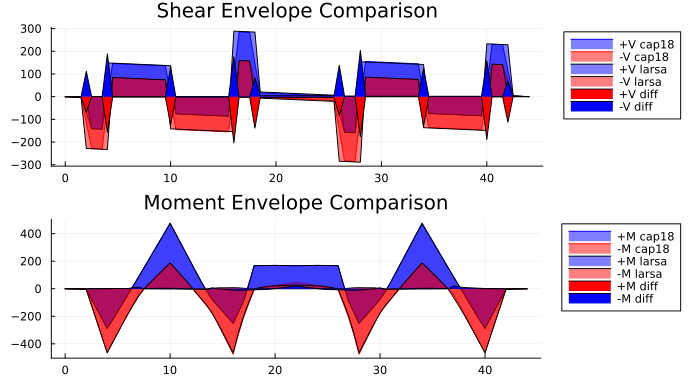

In [24]:
#| fig-cap: "Comparison: Service Shear and Moment Envelope Diagrams"
plot_env_comparison(se_cap18_srv, se_larsa_srv, me_cap18_srv, me_larsa_srv, legend_pos=legend_pos, size=(x_size, y_size))

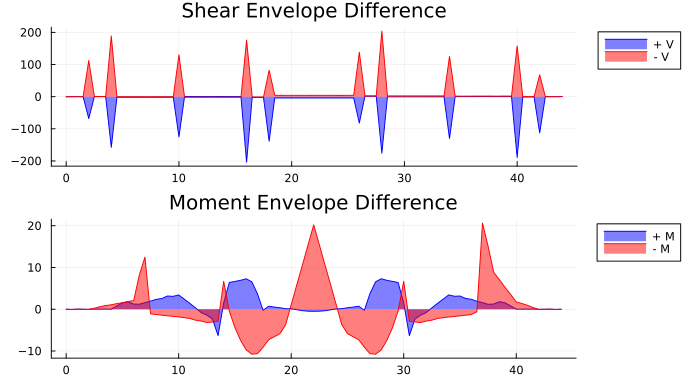

In [25]:
#| fig-cap: "Comparison: Service Shear and Moment Envelope Difference"
plot_difference(
	se_cap18_srv, se_larsa_srv, me_cap18_srv, me_larsa_srv,
	shear_title= "Shear Envelope Difference",
	moment_title= "Moment Envelope Difference",
)

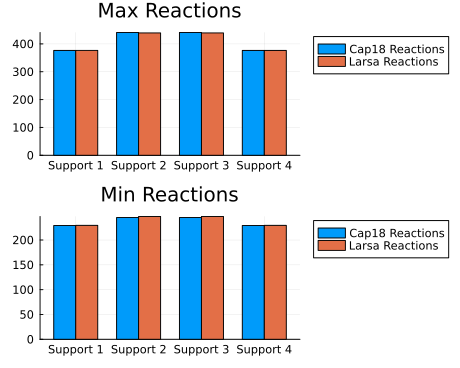

In [26]:
#| fig-cap: "Comparison: Service Reactions"
ctg = repeat(["Cap18 Reactions", "Larsa Reactions"], inner = 4)
nam = repeat("Support " .* string.(1:4), outer = 2)
plt1 = stats.groupedbar(nam, hcat(r_cap18_srv.max_reaction, r_larsa_srv.max_reaction), 
    bar_position = :dodge, bar_width=0.7, group=ctg, title = title="Max Reactions",
        )
plt2 = stats.groupedbar(nam, hcat(r_cap18_srv.min_reaction, r_larsa_srv.min_reaction), 
    bar_position = :dodge, bar_width=0.7, group=ctg, title="Min Reactions",
        )

plot(plt1, plt2, layout=(2, 1), legend=legend_pos)

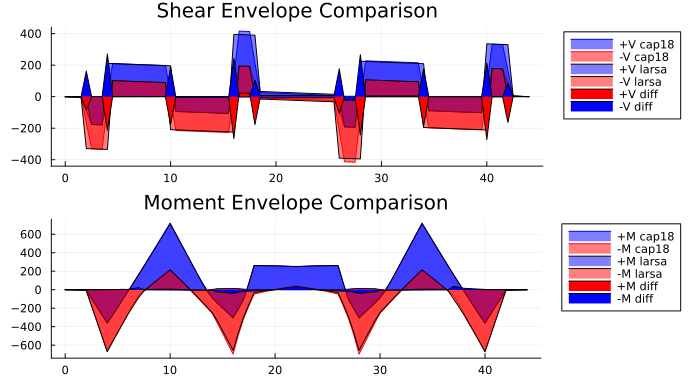

In [27]:
#| fig-cap: "Comparison: Strength Shear and Moment Envelope Diagrams"
plot_env_comparison(se_cap18_str, se_larsa_str, me_cap18_str, me_larsa_str, legend_pos=legend_pos, size=(x_size, y_size))

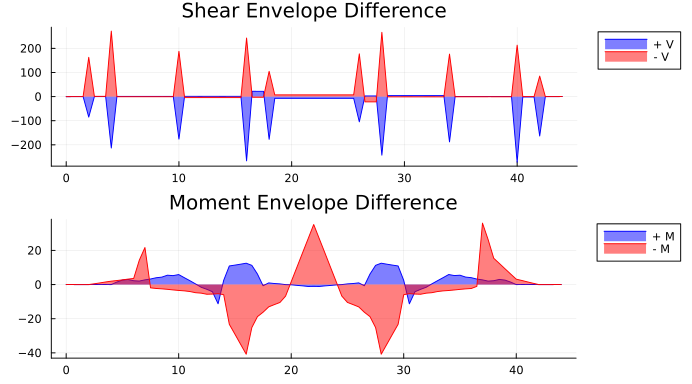

In [28]:
#| fig-cap: "Comparison: Strength Shear and Moment Envelope Difference"
plot_difference(
	se_cap18_str, se_larsa_str, me_cap18_str, me_larsa_str,
	shear_title= "Shear Envelope Difference",
	moment_title= "Moment Envelope Difference",
)